In [120]:
import pandas as pd
from scipy import stats
import pingouin as pg
import statsmodels.api as sm
from scipy.stats import chi2
import numpy as np
from statsmodels.stats.anova import AnovaRM
import statsmodels.formula.api as smf
from scipy.stats import kruskal
import scikit_posthocs as sp
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.anova import anova_lm
from scipy.stats import levene, shapiro
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [100]:
df = pd.read_csv('/content/drive/MyDrive/Csv folder/server_response_time_replicates.csv')

print(df.head())


   Server Server Type Security Protocol      Time  Response Time
0       1       Linux               SSL  Baseline      93.881199
1       2     Windows               TLS  Baseline     160.105153
2       3     Windows               SSL  Baseline     134.286198
3       4       Linux               TLS  Baseline     109.503697
4       5     Windows               SSL  Baseline     132.966562


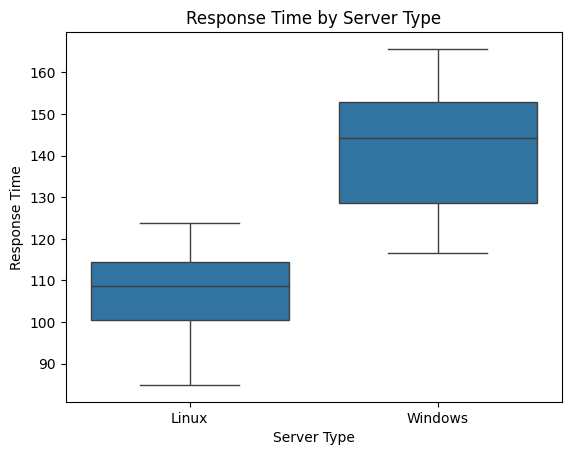

Shapiro-Wilk Test Results for Normality:
                W       p-value
Linux    0.966204  3.376437e-11
Windows  0.952769  4.005762e-12


In [85]:
sns.boxplot(x='Server Type', y='Response Time', data=df)
plt.title('Response Time by Server Type')
plt.show()

results = {}

for server_type in df['Server Type'].unique():
    group_data = df[df['Server Type'] == server_type]['Response Time']
    shapiro_test = stats.shapiro(group_data)
    results[server_type] = {
        'W': shapiro_test.statistic,
        'p-value': shapiro_test.pvalue
    }
shapiro_results_df = pd.DataFrame(results).T
print("Shapiro-Wilk Test Results for Normality:")
print(shapiro_results_df)

In [92]:
df_pivot = df.pivot_table(index='Server', columns='Time', values='Response Time', aggfunc='mean')
df_pivot = df_pivot.dropna()

def mauchly_test(data):
    n = len(data)
    k = data.shape[1]


    means = data.mean(axis=0).values


    grand_mean = means.mean()


    cov_matrix = np.cov(data.T)


    W = (np.linalg.det(cov_matrix) ** (n - 1)) / np.prod([np.linalg.det(cov_matrix + np.outer(means - grand_mean, means - grand_mean)) for means in means])


    chi_square = -((n - 1 - (2 * k)) * np.log(W))
    p_value = 1 - chi2.cdf(chi_square, (k - 1) * (k - 2) / 2)

    return W, p_value


W, p_value = mauchly_test(df_pivot)
print(f"Mauchly's W: {W}, p-value: {p_value}")

Mauchly's W: 1.018202617286723e+88, p-value: 1.0


In [93]:
levene_results = pg.homoscedasticity(data=df, dv='Response Time', group='Server')

print(levene_results)

               W          pval  equal_var
levene  6.471223  2.862253e-16      False


In [102]:
duplicates = df[df.duplicated(subset=['Server'], keep=False)]
if not duplicates.empty:
    print("Duplicate entries found:")
    print(duplicates)
else:
    print("No duplicate entries found. Data is independent.")

Duplicate entries found:
      Server Server Type Security Protocol      Time  Response Time
0          1       Linux               SSL  Baseline      93.881199
1          2     Windows               TLS  Baseline     160.105153
2          3     Windows               SSL  Baseline     134.286198
3          4       Linux               TLS  Baseline     109.503697
4          5     Windows               SSL  Baseline     132.966562
...      ...         ...               ...       ...            ...
1195      16     Windows               TLS  2 Months     156.739996
1196      17       Linux               TLS  2 Months     109.107500
1197      18     Windows               TLS  2 Months     165.600043
1198      19       Linux               TLS  2 Months     103.615543
1199      20     Windows               SSL  2 Months     151.112120

[1200 rows x 5 columns]


In [104]:
unique_servers = df['Server'].unique()
print("Unique Server Types:", unique_servers)

for server in unique_servers:

    count = df[df['Server'] == server]['Server Type'].nunique()
    print(f"Number of unique server types in {server}: {count}")

Unique Server Types: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Number of unique server types in 1: 1
Number of unique server types in 2: 1
Number of unique server types in 3: 1
Number of unique server types in 4: 1
Number of unique server types in 5: 1
Number of unique server types in 6: 1
Number of unique server types in 7: 1
Number of unique server types in 8: 1
Number of unique server types in 9: 1
Number of unique server types in 10: 1
Number of unique server types in 11: 1
Number of unique server types in 12: 1
Number of unique server types in 13: 1
Number of unique server types in 14: 1
Number of unique server types in 15: 1
Number of unique server types in 16: 1
Number of unique server types in 17: 1
Number of unique server types in 18: 1
Number of unique server types in 19: 1
Number of unique server types in 20: 1


In [124]:
df.rename(columns={'Response Time': 'Response_Time', 'Server Type': 'Server_Type', 'Security Protocol': 'Security_Protocol'}, inplace=True)
model = ols('Response_Time ~ C(Server_Type) * C(Security_Protocol)* C(Time)', data=df).fit()


anova_results = anova_lm(model)

print("\nThree-Way ANOVA Results:")
print(anova_results)


Three-Way ANOVA Results:
                                                 df         sum_sq  \
C(Server_Type)                                  1.0  335713.341659   
C(Security_Protocol)                            1.0    5354.762227   
C(Time)                                         2.0   10619.066481   
C(Server_Type):C(Security_Protocol)             1.0   31262.962504   
C(Server_Type):C(Time)                          2.0   18702.178455   
C(Security_Protocol):C(Time)                    2.0    1731.343618   
C(Server_Type):C(Security_Protocol):C(Time)     2.0    1603.738914   
Residual                                     1188.0   95431.223870   

                                                   mean_sq            F  \
C(Server_Type)                               335713.341659  4179.213403   
C(Security_Protocol)                           5354.762227    66.660127   
C(Time)                                        5309.533240    66.097083   
C(Server_Type):C(Security_Protocol)        

In [131]:
print(df.head())


print("DataFrame Shape:", df.shape)

print("Unique Server Types:", df['Server_Type'].unique())
print("Unique Security Protocols:", df['Security_Protocol'].unique())
print("Unique Times:", df['Time'].unique())

   Server Server_Type Security_Protocol      Time  Response_Time
0       1       Linux               SSL  Baseline      93.881199
1       2     Windows               TLS  Baseline     160.105153
2       3     Windows               SSL  Baseline     134.286198
3       4       Linux               TLS  Baseline     109.503697
4       5     Windows               SSL  Baseline     132.966562
DataFrame Shape: (1200, 5)
Unique Server Types: ['Linux' 'Windows']
Unique Security Protocols: ['SSL' 'TLS']
Unique Times: ['Baseline' '1 Month' '2 Months']


In [132]:
means = df.groupby(['Server_Type', 'Security_Protocol', 'Time']).mean().reset_index()

print("Means DataFrame:")
print(means)

if means.empty:
    print("Means DataFrame is empty. Please check your input data.")


Means DataFrame:
   Server_Type Security_Protocol      Time     Server  Response_Time
0        Linux               SSL   1 Month   6.500000     113.475776
1        Linux               SSL  2 Months   6.500000     116.379736
2        Linux               SSL  Baseline   6.500000     102.672297
3        Linux               TLS   1 Month  12.142857     107.553788
4        Linux               TLS  2 Months  12.142857     111.416239
5        Linux               TLS  Baseline  12.142857      97.233989
6      Windows               SSL   1 Month  10.200000     129.981283
7      Windows               SSL  2 Months  10.200000     132.875355
8      Windows               SSL  Baseline  10.200000     139.458415
9      Windows               TLS   1 Month  12.000000     144.339316
10     Windows               TLS  2 Months  12.000000     154.990024
11     Windows               TLS  Baseline  12.000000     149.531083


In [135]:
post_hoc_results = pg.pairwise_ttests(
    data=df,
    dv='Response_Time',
    between=['Server_Type', 'Security_Protocol'],
    padjust='bonf'
)


print("\nPost-Hoc Test Results for Server Type and Security Protocol:")
print(post_hoc_results)


post_hoc_results_time = pg.pairwise_ttests(
    data=df,
    dv='Response_Time',
    between=['Server_Type', 'Time'],
    padjust='bonf'
)


print("\nPost-Hoc Test Results for Server Type and Time:")
print(post_hoc_results_time)


post_hoc_results_protocol_time = pg.pairwise_ttests(
    data=df,
    dv='Response_Time',
    between=['Security_Protocol', 'Time'],
    padjust='bonf'
)


print("\nPost-Hoc Test Results for Security Protocol and Time:")
print(post_hoc_results_protocol_time)


/usr/local/lib/python3.10/dist-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
/usr/local/lib/python3.10/dist-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)



Post-Hoc Test Results for Server Type and Security Protocol:
                          Contrast Server_Type      A        B Paired  \
0                      Server_Type           -  Linux  Windows  False   
1                Security_Protocol           -    SSL      TLS  False   
2  Server_Type * Security_Protocol       Linux    SSL      TLS  False   
3  Server_Type * Security_Protocol     Windows    SSL      TLS  False   

  Parametric          T          dof alternative          p-unc        p-corr  \
0       True -47.584813   909.994039   two-sided  4.066959e-249           NaN   
1       True   2.005241  1154.492650   two-sided   4.517038e-02           NaN   
2       True   7.476071   510.396781   two-sided   3.358577e-13  6.717154e-13   
3       True -15.348930   520.249596   two-sided   3.963699e-44  7.927398e-44   

  p-adjust        BF10    hedges  
0      NaN  8.344e+273 -2.865555  
1      NaN       0.473  0.111918  
2     bonf   2.458e+10  0.599143  
3     bonf   6.993e+40 -1.

/usr/local/lib/python3.10/dist-packages/pingouin/pairwise.py:28: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)
